## Heart disease patients clasterization
Tymoteusz Urban, Karolina Mączka

In [34]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler, Normalizer, MinMaxScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, calinski_harabasz_score, davies_bouldin_score

## Data exploration

In [3]:
df = pd.read_csv('heart_disease_patients.csv')
df.drop('id', axis=1, inplace=True)
raw_data = df
print(df.head())

   id  age  sex  cp  trestbps  chol  fbs  restecg  thalach  exang  oldpeak   
0   1   63    1   1       145   233    1        2      150      0      2.3  \
1   2   67    1   4       160   286    0        2      108      1      1.5   
2   3   67    1   4       120   229    0        2      129      1      2.6   
3   4   37    1   3       130   250    0        0      187      0      3.5   
4   5   41    0   2       130   204    0        2      172      0      1.4   

   slope  
0      3  
1      2  
2      2  
3      3  
4      1  


1. age - age in years
2. sex - sex (1 = male; 0 = female)
3. cp - chest pain type (1 = typical angina; 2 = atypical angina; 3 = non-anginal pain; 4 = asymptomatic)
4. trestbps - resting blood pressure (in mm Hg on admission to the hospital)
5. chol - serum cholestoral in mg/dl
6. fbs - fasting blood sugar > 120 mg/dl (1 = true; 0 = false)
7. restecg - resting electrocardiographic results (0 = normal; 1 = having ST-T; 2 = hypertrophy)
8. thalach - maximum heart rate achieved
9. exang - exercise induced angina (1 = yes; 0 = no)
10. oldpeak - ST depression induced by exercise relative to rest
11. slope - the slope of the peak exercise ST segment (1 = upsloping; 2 = flat; 3 = downsloping)

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 303 entries, 0 to 302
Data columns (total 12 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   id        303 non-null    int64  
 1   age       303 non-null    int64  
 2   sex       303 non-null    int64  
 3   cp        303 non-null    int64  
 4   trestbps  303 non-null    int64  
 5   chol      303 non-null    int64  
 6   fbs       303 non-null    int64  
 7   restecg   303 non-null    int64  
 8   thalach   303 non-null    int64  
 9   exang     303 non-null    int64  
 10  oldpeak   303 non-null    float64
 11  slope     303 non-null    int64  
dtypes: float64(1), int64(11)
memory usage: 28.5 KB


In [5]:
df.isnull().sum()

id          0
age         0
sex         0
cp          0
trestbps    0
chol        0
fbs         0
restecg     0
thalach     0
exang       0
oldpeak     0
slope       0
dtype: int64

There are no null values, all variables are clean and properly encoded

array([[<Axes: title={'center': 'id'}>, <Axes: title={'center': 'age'}>,
        <Axes: title={'center': 'sex'}>],
       [<Axes: title={'center': 'cp'}>,
        <Axes: title={'center': 'trestbps'}>,
        <Axes: title={'center': 'chol'}>],
       [<Axes: title={'center': 'fbs'}>,
        <Axes: title={'center': 'restecg'}>,
        <Axes: title={'center': 'thalach'}>],
       [<Axes: title={'center': 'exang'}>,
        <Axes: title={'center': 'oldpeak'}>,
        <Axes: title={'center': 'slope'}>]], dtype=object)

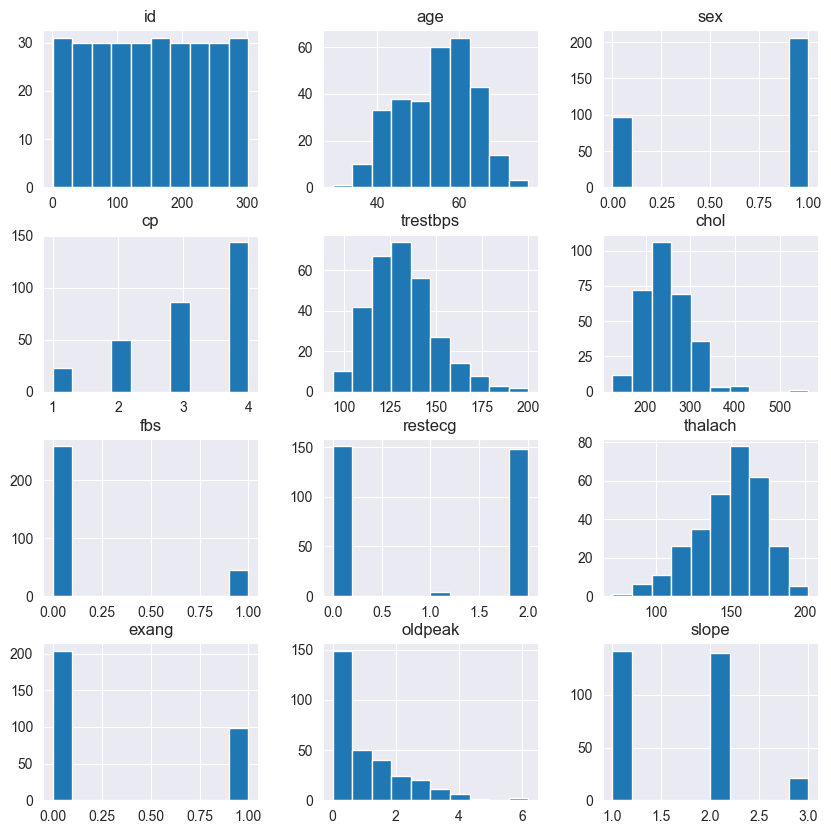

In [6]:
df.hist(figsize=(10,10))

<Axes: >

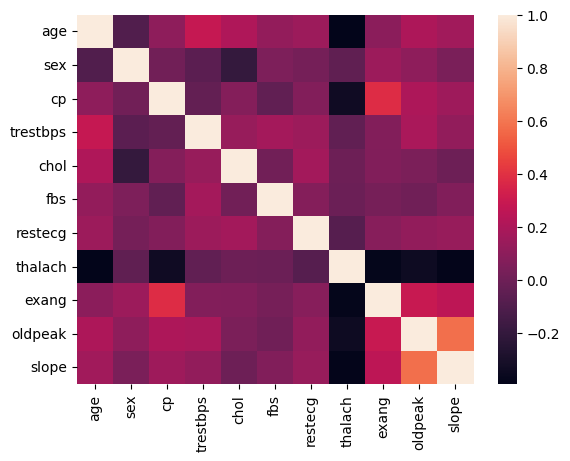

In [14]:
sns.heatmap(df.corr())

There is quite high correlation between oldpeak and slope and also between cp and exang, but is it big enough to delete any of the columns?

In [8]:
print(f"oldpeak and slope correlation: {df[['oldpeak', 'slope']].corr().iloc[0,1]}")
print(f"cp and exang correlation: {df[['cp', 'exang']].corr().iloc[0,1]}")

oldpeak and slope correlation: 0.5775368167291409
cp and exang correlation: 0.38405952636486906


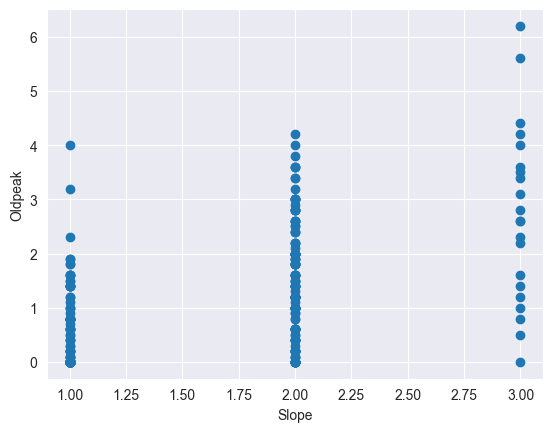

In [12]:
plt.scatter(df['slope'], df['oldpeak'])
plt.xlabel('Slope')
plt.ylabel('Oldpeak')
plt.show()

In [37]:
# Another approach
def calc_vif(X):
    vif = pd.DataFrame()
    vif["variables"] = X.columns
    vif["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
    return vif

In [38]:
calc_vif(df)

,variables,VIF
0,age,40.471744
1,sex,3.231010
2,cp,13.035948
3,trestbps,64.649980
4,chol,30.072029
5,fbs,1.217729
6,restecg,2.119624
7,thalach,34.695005
8,exang,2.027199
9,oldpeak,2.988769


Which variables should we drop? According to traditional correlation between variables it could be slope, but after calculatin VIF it seems that age, trestbps, chol and thalach are highly correlated with the other variables.

## Preprocessing

In [10]:
# Outliers removal - replace lower_bound and upper_bound, only numeric columns
def replace_outliers(data, k=1.5):
    """
    Removes outliers from a pandas DataFrame using the interquartile range (IQR) method.

    :param data: dataframe
    :param k: A multiplier to adjust the outlier threshold. By default, k is set to 1.5.
    :return: dataframe
    """
    for col in ['age', 'trestbps', 'chol', 'thalach', 'oldpeak']:
        q1, q3 = np.percentile(data[col], [25, 75])
        iqr = q3 - q1
        lower_bound = q1 - k * iqr
        upper_bound = q3 + k * iqr
        mask = (data[col] < lower_bound)
        data.loc[mask, col] = lower_bound
        mask = (data[col] > upper_bound)
        data.loc[mask, col] = upper_bound
    return data

In [11]:
replace_outliers(df)

,id,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope
0,1,63.0,1,1,145,233,1,2,150.0,0,2.3,3
1,2,67.0,1,4,160,286,0,2,108.0,1,1.5,2
2,3,67.0,1,4,120,229,0,2,129.0,1,2.6,2
3,4,37.0,1,3,130,250,0,0,187.0,0,3.5,3
4,5,41.0,0,2,130,204,0,2,172.0,0,1.4,1
...,...,...,...,...,...,...,...,...,...,...,...,...
298,299,45.0,1,1,110,264,0,0,132.0,0,1.2,2
299,300,68.0,1,4,144,193,1,0,141.0,0,3.4,2
300,301,57.0,1,4,130,131,0,0,115.0,1,1.2,2
301,302,57.0,0,2,130,236,0,2,174.0,0,0.0,2


In [6]:
# Instead manual deletion of variables we could use PCA for reducing dimensionality
def remove_overshadowing(data):
    """
    Performs Principal Component Analysis (PCA) on a given dataset.

    :param data: dataframe
    :return:
            A reduced version of the input DataFrame, containing the first n principal components
            where n is the smallest number of components that explain at least 95% of the variance in the data.
            The columns of the new DataFrame are named "PC1", "PC2", etc.

    """
    # Perform PCA
    pca = PCA()
    X_pca = pca.fit_transform(data)

    # Determine the number of principal components to retain
    explained_variances = pca.explained_variance_ratio_
    cumulative_variances = np.cumsum(explained_variances)
    n_components = np.argmax(cumulative_variances > 0.95) + 1

    # Retain the first n principal components
    X_reduced = X_pca[:, :n_components]

    # Convert back to a pandas DataFrame
    df_reduced = pd.DataFrame(X_reduced, columns=["PC"+str(i) for i in range(1, n_components+1)])
    
    return df_reduced

We will also need to scale our data - we can try 3 different ways to do it

In [13]:
def standarize(X):
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)
    X = pd.DataFrame(X_scaled, columns=X.columns)
    return X


def normalize(X):
    normalizer = Normalizer()
    X_normalized = normalizer.fit_transform(X)
    X = pd.DataFrame(X_normalized, columns=X.columns)
    return X


def minmax(X):
    minmaxer = MinMaxScaler()
    X_scaled = minmaxer.fit_transform(X)
    X = pd.DataFrame(X_scaled, columns=X.columns, index=X.index)
    return X

## Algorithms

In [ ]:
# We will use functions from other python files, so we don't have to run whole notebook every time
from preprocessing import standarize, minmax, normalize, replace_outliers
from KMeans import k_means_alg

First we prepare methods for finding optimal number of clusters

In [22]:
def num_of_clus_elbow(data) -> int:
    """
        Finds optimal number of clusters using elbow method.

        :param data: dataframe
        :return: number of clusters
    """
    sum_of_squared_distances = []
    K = range(1, 10)
    for num_clusters in K:
        kmeans = KMeans(n_clusters=num_clusters, n_init=10)
        kmeans.fit(data)
        sum_of_squared_distances.append(kmeans.inertia_)

    # finding elbow point
    sd = np.diff(sum_of_squared_distances, 2)
    elbow_point = np.argmax(sd) + 2

    plt.figure(figsize=(8, 5))
    plt.plot(range(1, 10), sum_of_squared_distances, marker='o')
    plt.xlabel('Number of clusters')
    plt.ylabel('WCSS')
    plt.show()

    return elbow_point

In [38]:
def num_of_clus_silhouette(data) -> int:
    """
    Finds optimal number of clusters using silhouette method.

    :param data: dataframe
    :return: number of clusters
    """
    silhouette_scores = []
    for i in range(2, 11):
        kmeans = KMeans(n_clusters=i, init='k-means++', max_iter=300, n_init=10, random_state=0)
        kmeans.fit(data)
        score = silhouette_score(data, kmeans.labels_)
        silhouette_scores.append(score)

    silhouette_point = np.argmax(silhouette_scores) + 2

    plt.figure(figsize=(8, 5))
    plt.plot(range(2, 11), silhouette_scores, marker='o')
    plt.xlabel('Number of clusters')
    plt.ylabel('Silhouette score')
    plt.show()

    return silhouette_point

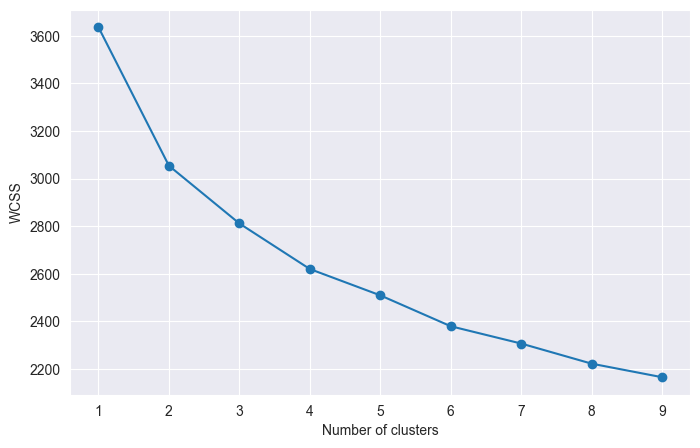

Elbow method: 2


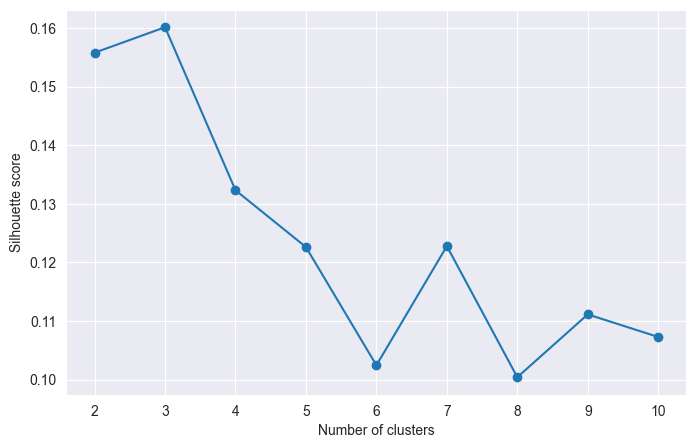

Silhouette method: 3


In [40]:
# Let's check elbow method
df_clusters = replace_outliers(raw_data)
df_clusters = standarize(df_clusters)
print('Elbow method:', num_of_clus_elbow(df_clusters))
print('Silhouette method:', num_of_clus_silhouette(df_clusters))

We can see that returned values are different. Now we make test it on a baseline model:

In [41]:
for i in [2,3]:
    y_kmeans = k_means_alg(df_clusters, num_clusters=i)
    print(f"silhouette score: {silhouette_score(df_clusters, y_kmeans)}")
    print(f"calinski harabasz score: {calinski_harabasz_score(df_clusters, y_kmeans)}")
    print(f"davies bouldin score: {davies_bouldin_score(df_clusters, y_kmeans)}")

number of clusters: 2
silhouette score: 0.15578945339139674
calinski harabasz score: 57.369460608546326
davies bouldin score: 2.231110432005108
number of clusters: 3
silhouette score: 0.1601401541313597
calinski harabasz score: 44.02039341566106
davies bouldin score: 2.024706635230446


Results vary depending on the score used, but overall the best results are for 2 clusters. On the other hand, 2 clusters may be too little and 3 sounds more reasonable

In [ ]:
# To be continued ...